In [1]:
cd ../..

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans


In [2]:
import os
import numpy as np
import pandas as pd
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, MaxPool1D, GlobalMaxPool1D, Flatten, Dropout, LeakyReLU, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from gans.utils import create_gan
from utils.windowing import windowing_dataframe, transform_windows_df
from utils.preprocess import filter_by_activity_index, calc_consultant
from utils.utils import check_dir_creation
from utils.plotting import plot_n_heatmaps, plot_n_lineplots
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def create_discriminator(input_shape):
    discriminator = Sequential()
    discriminator.add(Conv1D(8, kernel_size=9, activation='relu', input_shape=input_shape))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.summary()
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, clipvalue=1.0, decay=1e-8), metrics=['accuracy'])
    return discriminator

In [4]:
def create_generator(latent_dim, kernel_num, kernel_size, small=True):
    if small:
        generator = Sequential()
        generator.add(Dense(125 * 3, kernel_initializer='he_uniform', input_shape=(latent_dim,)))
        generator.add(LeakyReLU())
        generator.add(Reshape((125, 3)))

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU())

        generator.add(Conv1DTranspose(kernel_num, kernel_size=4, strides=2, padding='same'))
        generator.add(LeakyReLU())

        generator.add(Conv1D(3, kernel_size=kernel_size, padding='same', kernel_initializer='he_uniform', activation='linear'))
    else:
        generator = Sequential()
        generator.add(Dense(125 * 3, kernel_initializer='he_uniform', input_shape=(latent_dim,)))
        generator.add(LeakyReLU())
        generator.add(Reshape((125, 3)))

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU())

        generator.add(Conv1D(kernel_num, kernel_size=5, kernel_initializer='he_uniform', padding='same'))#
        generator.add(LeakyReLU()) #

        generator.add(Conv1DTranspose(kernel_num, kernel_size=4, strides=2, padding='same'))
        generator.add(LeakyReLU())

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU()) #

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU()) #

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, padding='same', kernel_initializer='he_uniform', activation='linear'))
        
    #generator.summary()
    return generator

In [5]:
def train_gan(generator, discriminator, gan, x_train_activity, steps, random=False):
    start = 0
    for step in range(steps):
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        generated_sensor_data = generator.predict(random_latent_vectors)

        if random:
            index = np.random.choice(x_train_activity.shape[0], batch_size, replace=False)
            real_sensor_data = x_train_activity[index]
        else:
            stop = start + batch_size
            real_sensor_data = x_train_activity[start:stop]
            start += batch_size

        combined_sensor_data = np.concatenate([generated_sensor_data, real_sensor_data])
        labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])

        d_loss = discriminator.train_on_batch(combined_sensor_data, labels)

        misleading_targets = np.ones((batch_size, 1))

        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        if start > len(x_train_activity) - batch_size:
            start = 0

        if step % 100 == 0:
            print('discriminator loss:', d_loss)
            print('adversarial loss:', a_loss)

In [6]:
train_df = pd.read_hdf('./datasets/mydata/train_df.h5')
val_df = pd.read_hdf('./datasets/mydata/val_df.h5')
test_df = pd.read_hdf('./datasets/mydata/test_df.h5')

In [7]:
window_size = 5*50
step_size = int(window_size/2)
col_names = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'userAcceleration.c']
method ='sliding'

In [8]:
train_windowed_df = windowing_dataframe(train_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
val_windowed_df = windowing_dataframe(val_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
test_windowed_df = windowing_dataframe(test_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

In [9]:
input_cols = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [10]:
x_train_activity, _ = filter_by_activity_index(x=x_train, y=y_train, activity_idx=0)

In [11]:
### SVM

In [116]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
labels=["standing", "not-standind"]

In [117]:
input_cols = ['userAcceleration.c']
x_train_clf, y_train_clf = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val_clf, y_val_clf = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test_clf, y_test_clf = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [118]:
x_train_clf = x_train_clf.reshape((len(x_train_clf), window_size))
x_val_clf = x_val_clf.reshape((len(x_val_clf), window_size))
x_test_clf = x_test_clf.reshape((len(x_test_clf), window_size))

In [119]:
x_train_standing_clf, _ = filter_by_activity_index(x=x_train_clf, y=y_train_clf, activity_idx=0)
x_train_walking_clf, _ = filter_by_activity_index(x=x_train_clf, y=y_train_clf, activity_idx=1)
x_train_jogging_clf, _ = filter_by_activity_index(x=x_train_clf, y=y_train_clf, activity_idx=2)

In [120]:
samples = int(len(x_train_standing_clf)/2)
samples

773

In [121]:
x_train_clf = np.concatenate([x_train_standing_clf, x_train_walking_clf[:samples], x_train_jogging_clf[:samples]])

In [122]:
y_train_clf = np.concatenate([np.ones(len(x_train_standing_clf)), np.zeros(len(x_train_walking_clf[:samples])), np.zeros(len(x_train_jogging_clf[:samples]))])

In [123]:
svm_clf = SVC()
svm_clf.fit(x_train_clf, y_train_clf)

SVC()

In [124]:
y_train_head = svm_clf.predict(x_train_clf)
print(classification_report(y_train_clf, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      0.70      0.82      1442
not-standind       0.78      1.00      0.88      1547

    accuracy                           0.85      2989
   macro avg       0.89      0.85      0.85      2989
weighted avg       0.89      0.85      0.85      2989



In [125]:
int(len(y_train_head)/2)

1494

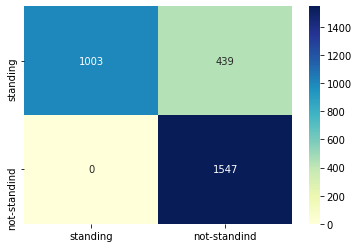

In [127]:
cm = confusion_matrix(y_train_clf, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')